In [ ]:
!conda install -y pandas numpy

### Preparing data for multi-label image classification

Each original chest x-ray image is 1024×1024 in size. We used 224×224 input resolution to obtain initial results, and then we obtained results on the full resolution. The input dataset is split into training/validation and testing without patient overlap between these sets and the 14 diseases are modeled as 14 binary outputs of a multi-label classifier. Each disease output indicates the presence/absence of the disease and “no disease” is represented as zeros for all labels. We first split the data into three sets: training, validation, and testing, based on patient IDs.

In [109]:
import pandas as pd
import numpy as np
import urllib.request
import boto3

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()
sess = sagemaker.Session()
bucket='analytics-serverless-west'
prefix = 'sagemaker/x-ray'

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

        
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)

def download_from_s3(bucket, key, local_file_name):
    s3 = boto3.resource('s3')
    s3.Bucket(bucket).download_file(key, local_file_name)

trainper = 0.7
valper = 0.1
file_name = 'Data_Entry_2017.csv'

download_from_s3(bucket, prefix+'/'+file_name, file_name)

a = pd.read_csv(file_name)
patient_ids = a['Patient ID']
uniq_pids = np.unique(patient_ids)
np.random.shuffle(uniq_pids)
total_ids = len(uniq_pids)
#total_ids = 30000 #pick a sample size you want to use to train and validate the model

In [110]:
a.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


### Make Train, Validation, and Testing datasets from the full image list

In [111]:
trainset = int(trainper*total_ids)
valset = trainset+int(valper*total_ids)
testset = trainset+valset

train = uniq_pids[:trainset]
val = uniq_pids[trainset+1:valset]
test = uniq_pids[valset+1:]
print('Number of patient ids: training: %d, validation: %d, testing: %d'%(len(train), len(val), len(test)))

traindata = a.loc[a['Patient ID'].isin(train)]
valdata = a.loc[a['Patient ID'].isin(val)]
testdata = a.loc[a['Patient ID'].isin(test)]

traindata.to_csv('traindata.csv', sep=',', header=False, index=False)
valdata.to_csv('valdata.csv', sep=',', header=False, index=False)
testdata.to_csv('testdata.csv', sep=',', header=False, index=False)

Number of patient ids: training: 21563, validation: 3079, testing: 6161


Then, we create the ‘[lst](https://mxnet.incubator.apache.org/faq/recordio.html)’ files for multi-label classification where each disease is mapped to a set of binary labels.

In [112]:
import csv

def gen_set(csvfile, outputfile):
    disease_list = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', \
                   'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', \
                   'Hernia']
    alldiseases = {disease:i for i,disease in enumerate(disease_list)}
    with open(outputfile, 'w') as fp:
        with open(csvfile, 'r') as cfile:
            line = csv.reader(cfile, delimiter=',')
            index = 0
            for element in line:
                # the first column is the image filename, while the second
                # column has the list of diseases separated by |
                diseases = element[1].split('|')
                fp.write('%d\t'%index)
                for d in alldiseases:
                    if d in diseases:
                        fp.write('%d\t'%1)
                    else:
                        fp.write('%d\t'%0)
                fp.write('images/%s\n' % element[0])
                index += 1
                 
gen_set('traindata.csv', 'chestxraytrain.lst')
gen_set('valdata.csv', 'chestxrayval.lst')
gen_set('testdata.csv', 'chestxraytest.lst')      

In [113]:
t_csv = pd.read_csv('traindata.csv')
v_csv = pd.read_csv('valdata.csv')

t_csv.head()

,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.14300000000000002,0.14300000000000002.1,Unnamed: 11
0,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
1,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
2,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
3,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
4,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN


In [114]:
v_csv.head()

,00000008_000.png,Cardiomegaly,0,8,69,F,PA,2048,2500,0.171,0.171.1,Unnamed: 11
0,00000008_001.png,No Finding,1,8,70,F,PA,2048,2500,0.171,0.171,NaN
1,00000008_002.png,Nodule,2,8,73,F,PA,2048,2500,0.168,0.168,NaN
2,00000014_000.png,No Finding,0,14,61,F,PA,2048,2500,0.171,0.171,NaN
3,00000040_000.png,No Finding,0,40,67,M,PA,2500,2048,0.168,0.168,NaN
4,00000040_001.png,Emphysema,1,40,67,M,AP,2500,2048,0.168,0.168,NaN


Then we create recordio files using [im2rec.py](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py) for training and validation. We pass the option pack_label so that the recordio file is created as a multi-label file. For more details, please refer to the Amazon SageMaker multi-label image classification notebooks.

In [115]:
download('https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py')

### Only run the below cell once. This is an expensive operation

In [ ]:
!aws s3 sync s3://analytics-serverless-west/sagemaker/x-ray/images/ images/

In [116]:
!head -10 chestxraytest.lst

0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	images/00000002_000.png
1	0	0	0	0	0	1	0	0	0	0	0	0	0	0	images/00000009_000.png
2	0	0	1	0	0	0	0	0	0	0	0	0	0	0	images/00000010_000.png
3	0	0	0	0	0	0	0	1	0	0	0	0	0	0	images/00000011_000.png
4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	images/00000011_001.png
5	0	0	0	0	0	0	0	0	0	0	0	0	0	0	images/00000011_002.png
6	0	0	0	0	0	0	0	0	0	0	0	0	0	0	images/00000011_003.png
7	0	0	0	0	0	0	0	0	0	0	0	0	0	0	images/00000011_004.png
8	0	0	1	0	0	0	0	0	0	0	0	0	0	0	images/00000011_005.png
9	1	0	0	0	0	0	0	0	0	0	0	0	0	0	images/00000011_006.png


In [117]:
!python im2rec.py --pack-label chestxraytrain.lst .
!python im2rec.py --pack-label chestxrayval.lst .

Creating .rec file from /home/ec2-user/SageMaker/chestxraytrain.lst in /home/ec2-user/SageMaker
multiprocessing not available, fall back to single threaded encoding
time: 0.0586705207824707  count: 0
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
time: 53.599899768829346  count: 1000
time: 53.78526711463928  count: 2000
time: 54.013200521469116  count: 3000
time: 53.6976683139801  count: 4000
time: 53.34519624710083  count: 5000
time: 54.07750463485718  count: 6000
time: 53.62135601043701  count: 7000
libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
time: 53.41580605506897  count: 8000
time: 54.20130252838135  count: 9000
time: 53.700379610061646  count: 10000
time: 54.05881881713867  count: 11000
time: 54.3556752204895  count: 12000
time: 54.17163586616516  count: 13000
time: 53.96117687225342  count: 14000
time: 54.45259714126587  count: 15000
time: 53.820563554763794  count: 16000
time: 54.

### Upload to S3

In [118]:
import boto3
import os

bucket = 'analytics-serverless-west'
prefix = 'sagemaker/x-ray'

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', 'chestxraytrain.rec')).upload_file('chestxraytrain.rec')
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', 'chestxrayval.rec')).upload_file('chestxrayval.rec')
s3_validation_data = 's3://{}/{}/validation/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_validation_data))

# boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', 'chestxraytrain.lst')).upload_file('chestxraytrain.lst')
# s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
# print('uploaded training data location: {}'.format(s3_train_data))

# boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', 'chestxrayval.lst')).upload_file('chestxrayval.lst')
# s3_validation_data = 's3://{}/{}/validation/{}'.format(bucket, prefix, key)
# print('uploaded validation data location: {}'.format(s3_validation_data))


uploaded training data location: s3://analytics-serverless-west/sagemaker/x-ray/train/recordio-pb-data
uploaded validation data location: s3://analytics-serverless-west/sagemaker/x-ray/validation/recordio-pb-data


### Image classification results on the chest x-ray dataset

We used the ResNet-50 model and first trained the network with 224×224 input image size. We used data augmentation techniques such as random cropping, and image transformations. Even though a chest x-ray image is different from ImageNet images, using a pre-trained model trained on the ImageNet dataset helps in achieving better classification accuracy. Hence, we used the use_pretrained_model hyperparameter in the Amazon SageMaker image classification algorithm to train the network. Since this is a multi-label classification, we set the multi_label parameter to 1. We resized the chest x-ray images to 256 before training so that the network can crop 224×224 regions from the input image.

The following code snippet shows how it can be done using the [Amazon SageMaker Estimator interface](https://sagemaker.readthedocs.io/en/latest/estimators.html) and the image classification algorithm.

In [122]:
s3train = 's3://{}/{}/train/'.format(bucket, prefix)
print(s3train)

training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
s3train = 's3://{}/{}/train/'.format(bucket, prefix)
s3validation = 's3://{}/{}/validation/'.format(bucket, prefix)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)


s3://analytics-serverless-west/sagemaker/x-ray/train/


In [ ]:
multilabel_ic = sagemaker.estimator.Estimator(training_image, role,
                        train_instance_count=1,
                        train_instance_type='ml.p3.16xlarge',
                        train_volume_size = 50, train_max_run = 360000,
                        input_mode= 'File', output_path=s3_output_location,
                        sagemaker_session=sess)
multilabel_ic.set_hyperparameters(num_layers=50, use_pretrained_model=1,
                                        image_shape = "3,224,224", num_classes=14,
                                        mini_batch_size=256, 
                                        resize=256,  epochs=100, 
                                        learning_rate=0.0005, optimizer='adam', 
                                        num_training_samples=80000,
                                        augmentation_type = 'crop_color_transform',
                                        precision_dtype='float32', multi_label = 1)
train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated',
                                                content_type='application/x-recordio',
                                                s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated',
                                                content_type='application/x-recordio',
                                                s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}
multilabel_ic.fit(inputs=data_channels, logs=True)


INFO:sagemaker:Creating training-job with name: image-classification-2018-11-04-01-12-09-407


2018-11-04 01:12:09 Starting - Starting the training job...
2018-11-04 01:12:12 Starting - Launching requested ML instances.........
2018-11-04 01:13:46 Starting - Preparing the instances for training......
2018-11-04 01:14:44 Downloading - Downloading input data.............................
Docker entrypoint called with argument(s): train

2018-11-04 01:19:52 Training - Training image download completed. Training in progress.[11/04/2018 01:19:57 INFO 140118357288768] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
2018-11-04 01:19:57 Reading default configuration from /opt/amazon/lib/python2.7/s

[11/04/2018 01:21:13 INFO 140118357288768] Epoch[0] Batch [20]#011Speed: 161.469 samples/sec#011accuracy=0.901865
2018-11-04 01:21:13 Epoch[0] Batch [20]#011Speed: 161.469 samples/sec#011accuracy=0.901865
2018-11-04 01:21:32 Epoch[0] Batch [40]#011Speed: 202.507 samples/sec#011accuracy=0.929300
[11/04/2018 01:21:32 INFO 140118357288768] Epoch[0] Batch [40]#011Speed: 202.507 samples/sec#011accuracy=0.929300
2018-11-04 01:21:51 Epoch[0] Batch [60]#011Speed: 221.373 samples/sec#011accuracy=0.937445
[11/04/2018 01:21:51 INFO 140118357288768] Epoch[0] Batch [60]#011Speed: 221.373 samples/sec#011accuracy=0.937445
[11/04/2018 01:22:10 INFO 140118357288768] Epoch[0] Batch [80]#011Speed: 232.181 samples/sec#011accuracy=0.941685
2018-11-04 01:22:10 Epoch[0] Batch [80]#011Speed: 232.181 samples/sec#011accuracy=0.941685
2018-11-04 01:22:29 Epoch[0] Batch [100]#011Speed: 239.002 samples/sec#011accuracy=0.943774
[11/04/2018 01:22:29 INFO 140118357288768] Epoch[0] Batch [100]#011Speed: 239.002 sample

2018-11-04 01:31:34 Epoch[2] Batch [20]#011Speed: 258.114 samples/sec#011accuracy=0.952408
[11/04/2018 01:31:34 INFO 140118357288768] Epoch[2] Batch [20]#011Speed: 258.114 samples/sec#011accuracy=0.952408
2018-11-04 01:31:53 Epoch[2] Batch [40]#011Speed: 266.549 samples/sec#011accuracy=0.955405
[11/04/2018 01:31:53 INFO 140118357288768] Epoch[2] Batch [40]#011Speed: 266.549 samples/sec#011accuracy=0.955405
2018-11-04 01:32:11 Epoch[2] Batch [60]#011Speed: 269.790 samples/sec#011accuracy=0.954996
[11/04/2018 01:32:11 INFO 140118357288768] Epoch[2] Batch [60]#011Speed: 269.790 samples/sec#011accuracy=0.954996
2018-11-04 01:32:30 Epoch[2] Batch [80]#011Speed: 271.043 samples/sec#011accuracy=0.955054
[11/04/2018 01:32:30 INFO 140118357288768] Epoch[2] Batch [80]#011Speed: 271.043 samples/sec#011accuracy=0.955054
[11/04/2018 01:32:49 INFO 140118357288768] Epoch[2] Batch [100]#011Speed: 271.774 samples/sec#011accuracy=0.954531
2018-11-04 01:32:49 Epoch[2] Batch [100]#011Speed: 271.774 sample

2018-11-04 01:42:07 Epoch[4] Batch [40]#011Speed: 266.440 samples/sec#011accuracy=0.955269
[11/04/2018 01:42:07 INFO 140118357288768] Epoch[4] Batch [40]#011Speed: 266.440 samples/sec#011accuracy=0.955269
[11/04/2018 01:42:26 INFO 140118357288768] Epoch[4] Batch [60]#011Speed: 269.723 samples/sec#011accuracy=0.954909
2018-11-04 01:42:26 Epoch[4] Batch [60]#011Speed: 269.723 samples/sec#011accuracy=0.954909
2018-11-04 01:42:44 Epoch[4] Batch [80]#011Speed: 271.275 samples/sec#011accuracy=0.954954
[11/04/2018 01:42:44 INFO 140118357288768] Epoch[4] Batch [80]#011Speed: 271.275 samples/sec#011accuracy=0.954954
2018-11-04 01:43:03 Epoch[4] Batch [100]#011Speed: 272.103 samples/sec#011accuracy=0.954498
[11/04/2018 01:43:03 INFO 140118357288768] Epoch[4] Batch [100]#011Speed: 272.103 samples/sec#011accuracy=0.954498
[11/04/2018 01:43:21 INFO 140118357288768] Epoch[4] Batch [120]#011Speed: 272.703 samples/sec#011accuracy=0.953946
2018-11-04 01:43:21 Epoch[4] Batch [120]#011Speed: 272.703 samp

[11/04/2018 01:53:16 INFO 140118357288768] Epoch[6] Batch [100]#011Speed: 272.117 samples/sec#011accuracy=0.954893
2018-11-04 01:53:16 Epoch[6] Batch [100]#011Speed: 272.117 samples/sec#011accuracy=0.954893
[11/04/2018 01:53:35 INFO 140118357288768] Epoch[6] Batch [120]#011Speed: 272.779 samples/sec#011accuracy=0.954386
2018-11-04 01:53:35 Epoch[6] Batch [120]#011Speed: 272.779 samples/sec#011accuracy=0.954386
[11/04/2018 01:53:54 INFO 140118357288768] Epoch[6] Batch [140]#011Speed: 273.027 samples/sec#011accuracy=0.953693
2018-11-04 01:53:54 Epoch[6] Batch [140]#011Speed: 273.027 samples/sec#011accuracy=0.953693
[11/04/2018 01:54:12 INFO 140118357288768] Epoch[6] Batch [160]#011Speed: 273.373 samples/sec#011accuracy=0.952487
2018-11-04 01:54:12 Epoch[6] Batch [160]#011Speed: 273.373 samples/sec#011accuracy=0.952487
[11/04/2018 01:54:31 INFO 140118357288768] Epoch[6] Batch [180]#011Speed: 273.651 samples/sec#011accuracy=0.951833
2018-11-04 01:54:31 Epoch[6] Batch [180]#011Speed: 273.65

[11/04/2018 02:03:49 INFO 140118357288768] Epoch[8] Batch [120]#011Speed: 272.574 samples/sec#011accuracy=0.954495
2018-11-04 02:03:49 Epoch[8] Batch [120]#011Speed: 272.574 samples/sec#011accuracy=0.954495
[11/04/2018 02:04:07 INFO 140118357288768] Epoch[8] Batch [140]#011Speed: 273.089 samples/sec#011accuracy=0.953826
2018-11-04 02:04:07 Epoch[8] Batch [140]#011Speed: 273.089 samples/sec#011accuracy=0.953826
[11/04/2018 02:04:26 INFO 140118357288768] Epoch[8] Batch [160]#011Speed: 273.252 samples/sec#011accuracy=0.952693
2018-11-04 02:04:26 Epoch[8] Batch [160]#011Speed: 273.252 samples/sec#011accuracy=0.952693
[11/04/2018 02:04:45 INFO 140118357288768] Epoch[8] Batch [180]#011Speed: 273.550 samples/sec#011accuracy=0.952061
2018-11-04 02:04:45 Epoch[8] Batch [180]#011Speed: 273.550 samples/sec#011accuracy=0.952061
[11/04/2018 02:05:03 INFO 140118357288768] Epoch[8] Batch [200]#011Speed: 273.784 samples/sec#011accuracy=0.951447
2018-11-04 02:05:03 Epoch[8] Batch [200]#011Speed: 273.78

[11/04/2018 02:14:58 INFO 140118357288768] Epoch[10] Batch [180]#011Speed: 273.475 samples/sec#011accuracy=0.952437
2018-11-04 02:14:58 Epoch[10] Batch [180]#011Speed: 273.475 samples/sec#011accuracy=0.952437
2018-11-04 02:15:17 Epoch[10] Batch [200]#011Speed: 273.665 samples/sec#011accuracy=0.951815
[11/04/2018 02:15:17 INFO 140118357288768] Epoch[10] Batch [200]#011Speed: 273.665 samples/sec#011accuracy=0.951815
[11/04/2018 02:15:35 INFO 140118357288768] Epoch[10] Batch [220]#011Speed: 273.727 samples/sec#011accuracy=0.950744
2018-11-04 02:15:35 Epoch[10] Batch [220]#011Speed: 273.727 samples/sec#011accuracy=0.950744
2018-11-04 02:15:54 Epoch[10] Batch [240]#011Speed: 273.742 samples/sec#011accuracy=0.949680
[11/04/2018 02:15:54 INFO 140118357288768] Epoch[10] Batch [240]#011Speed: 273.742 samples/sec#011accuracy=0.949680
[11/04/2018 02:16:13 INFO 140118357288768] Epoch[10] Batch [260]#011Speed: 273.720 samples/sec#011accuracy=0.950239
2018-11-04 02:16:13 Epoch[10] Batch [260]#011Spe

[11/04/2018 02:26:08 INFO 140118357288768] Epoch[12] Batch [240]#011Speed: 273.701 samples/sec#011accuracy=0.949807
2018-11-04 02:26:08 Epoch[12] Batch [240]#011Speed: 273.701 samples/sec#011accuracy=0.949807
2018-11-04 02:26:27 Epoch[12] Batch [260]#011Speed: 273.685 samples/sec#011accuracy=0.950374
[11/04/2018 02:26:27 INFO 140118357288768] Epoch[12] Batch [260]#011Speed: 273.685 samples/sec#011accuracy=0.950374
[11/04/2018 02:26:46 INFO 140118357288768] Epoch[12] Batch [280]#011Speed: 273.621 samples/sec#011accuracy=0.950338
2018-11-04 02:26:46 Epoch[12] Batch [280]#011Speed: 273.621 samples/sec#011accuracy=0.950338
[11/04/2018 02:27:04 INFO 140118357288768] Epoch[12] Batch [300]#011Speed: 274.032 samples/sec#011accuracy=0.950082
2018-11-04 02:27:04 Epoch[12] Batch [300]#011Speed: 274.032 samples/sec#011accuracy=0.950082
2018-11-04 02:27:14 Epoch[12] Train-accuracy=0.950075
2018-11-04 02:27:14 Epoch[12] Time cost=290.731
[11/04/2018 02:27:14 INFO 140118357288768] Epoch[12] Train-acc

2018-11-04 02:37:17 Epoch[14] Batch [300]#011Speed: 274.304 samples/sec#011accuracy=0.950570
[11/04/2018 02:37:17 INFO 140118357288768] Epoch[14] Batch [300]#011Speed: 274.304 samples/sec#011accuracy=0.950570
2018-11-04 02:37:28 Epoch[14] Train-accuracy=0.950583
2018-11-04 02:37:28 Epoch[14] Time cost=290.535
[11/04/2018 02:37:28 INFO 140118357288768] Epoch[14] Train-accuracy=0.950583
[11/04/2018 02:37:28 INFO 140118357288768] Epoch[14] Time cost=290.535
[11/04/2018 02:37:43 INFO 140118357288768] Epoch[14] Validation-accuracy=0.949398
2018-11-04 02:37:43 Epoch[14] Validation-accuracy=0.949398
2018-11-04 02:38:04 Epoch[15] Batch [20]#011Speed: 257.312 samples/sec#011accuracy=0.954799
[11/04/2018 02:38:04 INFO 140118357288768] Epoch[15] Batch [20]#011Speed: 257.312 samples/sec#011accuracy=0.954799
[11/04/2018 02:38:23 INFO 140118357288768] Epoch[15] Batch [40]#011Speed: 265.961 samples/sec#011accuracy=0.957201
2018-11-04 02:38:23 Epoch[15] Batch [40]#011Speed: 265.961 samples/sec#011accu

2018-11-04 02:47:57 Epoch[16] Validation-accuracy=0.949524
[11/04/2018 02:47:57 INFO 140118357288768] Epoch[16] Validation-accuracy=0.949524
2018-11-04 02:48:18 Epoch[17] Batch [20]#011Speed: 257.492 samples/sec#011accuracy=0.954985
[11/04/2018 02:48:18 INFO 140118357288768] Epoch[17] Batch [20]#011Speed: 257.492 samples/sec#011accuracy=0.954985
[11/04/2018 02:48:37 INFO 140118357288768] Epoch[17] Batch [40]#011Speed: 266.239 samples/sec#011accuracy=0.957290
2018-11-04 02:48:37 Epoch[17] Batch [40]#011Speed: 266.239 samples/sec#011accuracy=0.957290
2018-11-04 02:48:55 Epoch[17] Batch [60]#011Speed: 269.435 samples/sec#011accuracy=0.956949
[11/04/2018 02:48:55 INFO 140118357288768] Epoch[17] Batch [60]#011Speed: 269.435 samples/sec#011accuracy=0.956949
[11/04/2018 02:49:14 INFO 140118357288768] Epoch[17] Batch [80]#011Speed: 271.132 samples/sec#011accuracy=0.956828
2018-11-04 02:49:14 Epoch[17] Batch [80]#011Speed: 271.132 samples/sec#011accuracy=0.956828
[11/04/2018 02:49:32 INFO 14011

[11/04/2018 02:59:09 INFO 140118357288768] Epoch[19] Batch [60]#011Speed: 269.283 samples/sec#011accuracy=0.957141
2018-11-04 02:59:09 Epoch[19] Batch [60]#011Speed: 269.283 samples/sec#011accuracy=0.957141
[11/04/2018 02:59:27 INFO 140118357288768] Epoch[19] Batch [80]#011Speed: 271.242 samples/sec#011accuracy=0.957083
2018-11-04 02:59:27 Epoch[19] Batch [80]#011Speed: 271.242 samples/sec#011accuracy=0.957083
2018-11-04 02:59:46 Epoch[19] Batch [100]#011Speed: 272.094 samples/sec#011accuracy=0.956540
[11/04/2018 02:59:46 INFO 140118357288768] Epoch[19] Batch [100]#011Speed: 272.094 samples/sec#011accuracy=0.956540
2018-11-04 03:00:04 Epoch[19] Batch [120]#011Speed: 272.433 samples/sec#011accuracy=0.956026
[11/04/2018 03:00:04 INFO 140118357288768] Epoch[19] Batch [120]#011Speed: 272.433 samples/sec#011accuracy=0.956026
2018-11-04 03:00:23 Epoch[19] Batch [140]#011Speed: 272.916 samples/sec#011accuracy=0.955480
[11/04/2018 03:00:23 INFO 140118357288768] Epoch[19] Batch [140]#011Speed: 

[11/04/2018 03:10:18 INFO 140118357288768] Epoch[21] Batch [120]#011Speed: 272.464 samples/sec#011accuracy=0.956485
2018-11-04 03:10:18 Epoch[21] Batch [120]#011Speed: 272.464 samples/sec#011accuracy=0.956485
2018-11-04 03:10:37 Epoch[21] Batch [140]#011Speed: 272.917 samples/sec#011accuracy=0.955878
[11/04/2018 03:10:37 INFO 140118357288768] Epoch[21] Batch [140]#011Speed: 272.917 samples/sec#011accuracy=0.955878
2018-11-04 03:10:56 Epoch[21] Batch [160]#011Speed: 273.363 samples/sec#011accuracy=0.954773
[11/04/2018 03:10:56 INFO 140118357288768] Epoch[21] Batch [160]#011Speed: 273.363 samples/sec#011accuracy=0.954773
2018-11-04 03:11:14 Epoch[21] Batch [180]#011Speed: 273.455 samples/sec#011accuracy=0.954115
[11/04/2018 03:11:14 INFO 140118357288768] Epoch[21] Batch [180]#011Speed: 273.455 samples/sec#011accuracy=0.954115
[11/04/2018 03:11:33 INFO 140118357288768] Epoch[21] Batch [200]#011Speed: 273.612 samples/sec#011accuracy=0.953537
2018-11-04 03:11:33 Epoch[21] Batch [200]#011Spe

[11/04/2018 03:21:28 INFO 140118357288768] Epoch[23] Batch [180]#011Speed: 273.805 samples/sec#011accuracy=0.954414
2018-11-04 03:21:28 Epoch[23] Batch [180]#011Speed: 273.805 samples/sec#011accuracy=0.954414
2018-11-04 03:21:46 Epoch[23] Batch [200]#011Speed: 273.965 samples/sec#011accuracy=0.953833
[11/04/2018 03:21:46 INFO 140118357288768] Epoch[23] Batch [200]#011Speed: 273.965 samples/sec#011accuracy=0.953833
[11/04/2018 03:22:05 INFO 140118357288768] Epoch[23] Batch [220]#011Speed: 273.994 samples/sec#011accuracy=0.952963
2018-11-04 03:22:05 Epoch[23] Batch [220]#011Speed: 273.994 samples/sec#011accuracy=0.952963
2018-11-04 03:22:24 Epoch[23] Batch [240]#011Speed: 274.084 samples/sec#011accuracy=0.952054
[11/04/2018 03:22:24 INFO 140118357288768] Epoch[23] Batch [240]#011Speed: 274.084 samples/sec#011accuracy=0.952054
2018-11-04 03:22:42 Epoch[23] Batch [260]#011Speed: 274.165 samples/sec#011accuracy=0.952549
[11/04/2018 03:22:42 INFO 140118357288768] Epoch[23] Batch [260]#011Spe

[11/04/2018 03:32:38 INFO 140118357288768] Epoch[25] Batch [240]#011Speed: 273.620 samples/sec#011accuracy=0.952433
2018-11-04 03:32:38 Epoch[25] Batch [240]#011Speed: 273.620 samples/sec#011accuracy=0.952433
2018-11-04 03:32:57 Epoch[25] Batch [260]#011Speed: 273.765 samples/sec#011accuracy=0.952911
[11/04/2018 03:32:57 INFO 140118357288768] Epoch[25] Batch [260]#011Speed: 273.765 samples/sec#011accuracy=0.952911
[11/04/2018 03:33:15 INFO 140118357288768] Epoch[25] Batch [280]#011Speed: 273.851 samples/sec#011accuracy=0.952844
2018-11-04 03:33:15 Epoch[25] Batch [280]#011Speed: 273.851 samples/sec#011accuracy=0.952844
[11/04/2018 03:33:33 INFO 140118357288768] Epoch[25] Batch [300]#011Speed: 274.236 samples/sec#011accuracy=0.952537
2018-11-04 03:33:33 Epoch[25] Batch [300]#011Speed: 274.236 samples/sec#011accuracy=0.952537
2018-11-04 03:33:44 Epoch[25] Train-accuracy=0.952612
2018-11-04 03:33:44 Epoch[25] Time cost=290.575
[11/04/2018 03:33:44 INFO 140118357288768] Epoch[25] Train-acc

2018-11-04 03:43:47 Epoch[27] Batch [300]#011Speed: 274.363 samples/sec#011accuracy=0.953251
[11/04/2018 03:43:47 INFO 140118357288768] Epoch[27] Batch [300]#011Speed: 274.363 samples/sec#011accuracy=0.953251
2018-11-04 03:43:58 Epoch[27] Train-accuracy=0.953322
2018-11-04 03:43:58 Epoch[27] Time cost=290.477
[11/04/2018 03:43:58 INFO 140118357288768] Epoch[27] Train-accuracy=0.953322
[11/04/2018 03:43:58 INFO 140118357288768] Epoch[27] Time cost=290.477
[11/04/2018 03:44:14 INFO 140118357288768] Epoch[27] Validation-accuracy=0.947408
2018-11-04 03:44:14 Epoch[27] Validation-accuracy=0.947408
[11/04/2018 03:44:34 INFO 140118357288768] Epoch[28] Batch [20]#011Speed: 257.541 samples/sec#011accuracy=0.958705
2018-11-04 03:44:34 Epoch[28] Batch [20]#011Speed: 257.541 samples/sec#011accuracy=0.958705
[11/04/2018 03:44:53 INFO 140118357288768] Epoch[28] Batch [40]#011Speed: 266.222 samples/sec#011accuracy=0.959855
2018-11-04 03:44:53 Epoch[28] Batch [40]#011Speed: 266.222 samples/sec#011accu

2018-11-04 03:54:27 Epoch[29] Validation-accuracy=0.947033
[11/04/2018 03:54:27 INFO 140118357288768] Epoch[29] Validation-accuracy=0.947033
[11/04/2018 03:54:48 INFO 140118357288768] Epoch[30] Batch [20]#011Speed: 257.691 samples/sec#011accuracy=0.960021
2018-11-04 03:54:48 Epoch[30] Batch [20]#011Speed: 257.691 samples/sec#011accuracy=0.960021
[11/04/2018 03:55:06 INFO 140118357288768] Epoch[30] Batch [40]#011Speed: 266.594 samples/sec#011accuracy=0.961067
2018-11-04 03:55:06 Epoch[30] Batch [40]#011Speed: 266.594 samples/sec#011accuracy=0.961067
[11/04/2018 03:55:25 INFO 140118357288768] Epoch[30] Batch [60]#011Speed: 269.382 samples/sec#011accuracy=0.960174
2018-11-04 03:55:25 Epoch[30] Batch [60]#011Speed: 269.382 samples/sec#011accuracy=0.960174
2018-11-04 03:55:43 Epoch[30] Batch [80]#011Speed: 270.848 samples/sec#011accuracy=0.959780
[11/04/2018 03:55:43 INFO 140118357288768] Epoch[30] Batch [80]#011Speed: 270.848 samples/sec#011accuracy=0.959780
2018-11-04 03:56:02 Epoch[30] B

[11/04/2018 04:05:39 INFO 140118357288768] Epoch[32] Batch [60]#011Speed: 269.496 samples/sec#011accuracy=0.960741
2018-11-04 04:05:39 Epoch[32] Batch [60]#011Speed: 269.496 samples/sec#011accuracy=0.960741
2018-11-04 04:05:57 Epoch[32] Batch [80]#011Speed: 271.196 samples/sec#011accuracy=0.960493
[11/04/2018 04:05:57 INFO 140118357288768] Epoch[32] Batch [80]#011Speed: 271.196 samples/sec#011accuracy=0.960493
2018-11-04 04:06:16 Epoch[32] Batch [100]#011Speed: 271.963 samples/sec#011accuracy=0.959827
[11/04/2018 04:06:16 INFO 140118357288768] Epoch[32] Batch [100]#011Speed: 271.963 samples/sec#011accuracy=0.959827
2018-11-04 04:06:34 Epoch[32] Batch [120]#011Speed: 272.712 samples/sec#011accuracy=0.959247
[11/04/2018 04:06:34 INFO 140118357288768] Epoch[32] Batch [120]#011Speed: 272.712 samples/sec#011accuracy=0.959247
2018-11-04 04:06:53 Epoch[32] Batch [140]#011Speed: 273.055 samples/sec#011accuracy=0.958816
[11/04/2018 04:06:53 INFO 140118357288768] Epoch[32] Batch [140]#011Speed: 

2018-11-04 04:16:48 Epoch[34] Batch [120]#011Speed: 272.860 samples/sec#011accuracy=0.960082
[11/04/2018 04:16:48 INFO 140118357288768] Epoch[34] Batch [120]#011Speed: 272.860 samples/sec#011accuracy=0.960082
2018-11-04 04:17:06 Epoch[34] Batch [140]#011Speed: 273.170 samples/sec#011accuracy=0.959544
[11/04/2018 04:17:06 INFO 140118357288768] Epoch[34] Batch [140]#011Speed: 273.170 samples/sec#011accuracy=0.959544
2018-11-04 04:17:25 Epoch[34] Batch [160]#011Speed: 273.415 samples/sec#011accuracy=0.958529
[11/04/2018 04:17:25 INFO 140118357288768] Epoch[34] Batch [160]#011Speed: 273.415 samples/sec#011accuracy=0.958529
2018-11-04 04:17:44 Epoch[34] Batch [180]#011Speed: 273.569 samples/sec#011accuracy=0.957956
[11/04/2018 04:17:44 INFO 140118357288768] Epoch[34] Batch [180]#011Speed: 273.569 samples/sec#011accuracy=0.957956
2018-11-04 04:18:02 Epoch[34] Batch [200]#011Speed: 273.757 samples/sec#011accuracy=0.957439
[11/04/2018 04:18:02 INFO 140118357288768] Epoch[34] Batch [200]#011Spe

### Training with weighted loss

An additional feature introduced in image classification is the use of weighted loss to handle class imbalance. Typically, when training with a multi-label dataset, there might be imbalance between classes. This imbalance can lead to a network leaning towards learning one class over another. To avoid that, the Amazon SageMaker image classification algorithm uses the use_weighted_loss hyperparameter to balance the samples. When this parameter is set to 1, a weight value is calculated for each label based on the number of samples of that label in the training set. First, the number of samples in each class is calculated from the training set and the weight for loss update is set to N/N_l for that class where N is the total number of samples in the training set and N_l is the total number of samples for class l in the training set. This will weigh the loss calculated for gradient update differently for each class based on their weight thereby enabling balanced training. The average AUC increased to 0.814 when trained using the weighted loss feature enabled while still using 224×224 input resolution.

In [ ]:
multilabel_ic = sagemaker.estimator.Estimator(training_image, role,
                        train_instance_count=1,
                        train_instance_type='ml.p3.16xlarge',
                        train_volume_size = 50, train_max_run = 360000,
                        input_mode= 'File', output_path=s3_output_location,
                        sagemaker_session=sess)
# multilabel_ic.set_hyperparameters(num_layers=50, use_pretrained_model=1,
#                                         image_shape = "3,224,224", num_classes=14,
#                                         mini_batch_size=256, 
#                                         resize=256,  epochs=100, 
#                                         learning_rate=0.0005, optimizer='adam', 
#                                         num_training_samples=80000,
#                                         augmentation_type = 'crop_color_transform',
#                                         precision_dtype='float32', multi_label = 1)
multilabel_ic.set_hyperparameters(num_layers=50, use_pretrained_model=1,
                                        image_shape = "3,224,224", num_classes=14,
                                        mini_batch_size=256, resize=256,  epochs=100, 
                                        learning_rate=0.0005, optimizer='adam', 
                                        num_training_samples=80000, use_weighted_loss=1,
                                        augmentation_type = 'crop_color_transform',
                                        precision_dtype='float32', multi_label = 1)
train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated',
                                                content_type='application/x-recordio',
                                                s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated',
                                                content_type='application/x-recordio',
                                                s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}
multilabel_ic.fit(inputs=data_channels, logs=True)


### Training with mixed-precision

The Amazon SageMaker image classification algorithm now supports training in mixed-precision mode. This is controlled by the hyperparameter, precision_dtype, which can be set to ‘float32’ (default) or ‘float16’. In mixed-precision mode, the network computes the backward and forward pass in low-precision (float16) while maintaining the master weights in high-precision (float32). This enables the training to be faster while maintaining similar accuracy. By using the mixed-precision mode, the training time was reduced by 33 percent while obtaining the overall AUC of 0.821, which is similar to the one obtained with float32 training. The training time reduction was even greater when training using two instances for the high-resolution input (see the following section) and increased to 47 percent.

In [121]:
multilabel_ic = sagemaker.estimator.Estimator(training_image, role,
                        train_instance_count=1,
                        train_instance_type='ml.p3.16xlarge',
                        train_volume_size = 50, train_max_run = 360000,
                        input_mode= 'File', output_path=s3_output_location,
                        sagemaker_session=sess)
# multilabel_ic.set_hyperparameters(num_layers=50, use_pretrained_model=1,
#                                         image_shape = "3,224,224", num_classes=14,
#                                         mini_batch_size=256, 
#                                         resize=256,  epochs=100, 
#                                         learning_rate=0.0005, optimizer='adam', 
#                                         num_training_samples=80000,
#                                         augmentation_type = 'crop_color_transform',
#                                         precision_dtype='float32', multi_label = 1)
multilabel_ic.set_hyperparameters(num_layers=50, use_pretrained_model=1,
                                        image_shape = "3,224,224", num_classes=14,
                                        mini_batch_size=256, resize=256, epochs=100, 
                                        learning_rate=0.0005, optimizer='adam', 
                                        num_training_samples=80000, use_weighted_loss=1, 
                                        augmentation_type = 'crop_color_transform',
                                        precision_dtype='float16', multi_label = 1)

train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated',
                                                content_type='application/x-recordio',
                                                s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated',
                                                content_type='application/x-recordio',
                                                s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}
multilabel_ic.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: image-classification-2018-11-04-01-02-01-981


2018-11-04 01:02:02 Starting - Starting the training job...
2018-11-04 01:02:05 Starting - Launching requested ML instances.........
2018-11-04 01:03:37 Starting - Preparing the instances for training......
2018-11-04 01:04:45 Downloading - Downloading input data...
2018-11-04 01:05:12 Failed - Training job failed
..

ValueError: Error training image-classification-2018-11-04-01-02-01-981: Failed Reason: ClientError: Data download failed:S3 key: s3://analytics-serverless-west/validation/ matched no files on s3

### Training with high-resolution input

We then used the original input resolution by setting the image_shape parameter to 896×896. We used the use_weighted_loss feature and float32 precision for this training. We used this resolution because it allows the network to sample a 896×896 region from the 1024×1024 during data augmentation. Since the high resolution will use more memory, typically batch_size is reduced to train the network. However, because Amazon SageMaker image classification supports distributed training, we were able to maintain the batch_size by running the training across multiple instances. This is done by setting the [instance_count parameter](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTrainingJob.html) in the Amazon SageMaker training to 2. The average AUC for this resolution increased to 0.830, particularly for classes such as nodule, which can benefit from high-resolution input. When we trained with mixed_precision set to 1, the average AUC was 0.825. The training was done using the same code as before but setting the train_instance_count = 2, image_shape=”3,896,896” and not setting the resize parameter.



In [ ]:
multilabel_ic = sagemaker.estimator.Estimator(training_image, role, train_instance_count=2,
                                                train_instance_type='ml.p3.16xlarge',
                                                train_volume_size = 50, train_max_run = 360000,
                                                input_mode= 'File', output_path=s3_output_location,
                                                sagemaker_session=sess)

multilabel_ic.set_hyperparameters(num_layers=50, use_pretrained_model=1, 
                                        image_shape = "3,896,896", num_classes=14,
                                        mini_batch_size=64, epochs=100, 
                                        learning_rate=0.00025, optimizer='adam', 
                                        num_training_samples=80000, use_weighted_loss=1, 
                                        augmentation_type = 'crop_color_transform',
                                        precision_dtype='float32', multi_label = 1)

train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated',
                                                content_type='application/x-recordio',
                                                s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated',
                                                content_type='application/x-recordio',
                                                s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}
multilabel_ic.fit(inputs=data_channels, logs=True)

| Label | 224×224 | 224×224 with class balancing | 224×224 with mixed precision | 896×896 |
|-----------| :--------------------------: | :--------------------------: | :-------: | ---------: |
|Atelectasis | 0.772 |0.802 | 0.799 | 0.800 |
|Cardiomegaly | 0.859 | 0.899 | 0.906 | 0.884 |
|Effusion | 0.830 | 0.873 | 0.873 | 0.873 |
|Infiltration | 0.626 | 0.693 | 0.691 | 0.698 |
|Mass | 0.791 | 0.839 | 0.834 | 0.821 |
|Nodule | 0.716 | 0.743 | 0.751 | 0.817 |
|Pneumonia | 0.645 | 0.710 | 0.713 | 0.739 |
|Pneumothorax | 0.778 | 0.836 | 0.862 | 0.878 |
|Consolidation | 0.695 | 0.791 | 0.789 | 0.785 |
|Edema | 0.799 | 0.849 | 0.863 | 0.879| 
|Emphysema | 0.850 | 0.889 | 0.909 | 0.933 |
|Fibrosis | 0.764 | 0.791 | 0.811 | 0.822 |
|Pleural Thickening | 0.726 | 0.758 | 0.761 | 0.785 |
|Hernia | 0.903 | 0.929 | 0.940 | 0.911 |
|Average AUC | 0.768 | 0.814 | 0.821 | 0.830 |


### Deploy the model

***

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the topic mixture representing a given document.

Image-classification only supports encoded .jpg and .png image formats as inference input for now. The output is the probability values for all classes encoded in JSON format, or in JSON Lines format for batch transform.

This section involves several steps,

1. [Create Model](#CreateModel) - Create model for the training output
1. [Batch Transform](#BatchTransform) - Create a transform job to perform batch inference.
1. [Host the model for realtime inference](#HostTheModel) - Create an inference endpoint and perform realtime inference.

## Create Model

We now create a SageMaker Model from the training output. Using the model we can create a Batch Transform Job or an Endpoint Configuration.

In [9]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

# get the name of the training job completed below for this variable
job_name="image-classification-2018-11-03-07-10-36-441"
model_name = "x-ray-image-classification-model"
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

x-ray-image-classification-model
s3://analytics-serverless-west/sagemaker/x-ray/output/image-classification-2018-11-03-07-10-36-441/output/model.tar.gz
arn:aws:sagemaker:us-west-2:649037252677:model/x-ray-image-classification-model
CPU times: user 44.8 ms, sys: 0 ns, total: 44.8 ms
Wall time: 407 ms


### Realtime inference

We now host the model with an endpoint and perform realtime inference.

This section involves several steps,
1. [Create endpoint configuration](#CreateEndpointConfiguration) - Create a configuration defining an endpoint.
1. [Create endpoint](#CreateEndpoint) - Use the configuration to create an inference endpoint.
1. [Perform inference](#PerformInference) - Perform inference on some input data using the endpoint.
1. [Clean up](#CleanUp) - Delete the endpoint and model

#### Create Endpoint Configuration
At launch, we will support configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way.

In addition, the endpoint configuration describes the instance type required for model deployment, and at launch will describe the autoscaling configuration.

In [12]:
import time
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = model_name + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: x-ray-image-classification-model-epc--2018-11-03-16-23-12
Endpoint configuration arn:  arn:aws:sagemaker:us-west-2:649037252677:endpoint-config/x-ray-image-classification-model-epc--2018-11-03-16-23-12


#### Create Endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [16]:
%%time
import time

sage = boto3.client('sagemaker')
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = model_name + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sage.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: x-ray-image-classification-model-ep--2018-11-03-16-26-35
EndpointArn = arn:aws:sagemaker:us-west-2:649037252677:endpoint/x-ray-image-classification-model-ep--2018-11-03-16-26-35
CPU times: user 29.7 ms, sys: 0 ns, total: 29.7 ms
Wall time: 373 ms


In [17]:
# get the status of the endpoint
response = sage.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sage.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sage.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


If you see the message,

> `Endpoint creation ended with EndpointStatus = InService`

then congratulations! You now have a functioning inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console.

We will finally create a runtime object from which we can invoke the endpoint.

#### Perform Inference
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [18]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

In [20]:
!head -10 chestxraytest.lst

0	0	0	0	0	0	0	0	0	0	0	0	1	1	0	images/00000004_000.png
1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	images/00000016_000.png
2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	images/00000018_000.png
3	1	0	0	0	0	0	0	1	0	1	0	0	0	0	images/00000019_000.png
4	0	0	0	0	0	0	0	0	0	0	0	0	0	0	images/00000022_000.png
5	0	0	0	0	0	0	1	0	0	0	0	0	0	0	images/00000022_001.png
6	0	0	0	0	0	1	0	0	0	0	0	0	0	0	images/00000027_000.png
7	0	0	0	0	0	0	0	0	0	1	0	0	0	0	images/00000028_000.png
8	1	0	0	0	0	0	1	0	0	0	1	0	0	0	images/00000033_000.png
9	0	0	1	0	0	0	0	0	0	0	0	0	0	0	images/00000043_000.png


In [21]:
!pwd

/home/ec2-user/SageMaker


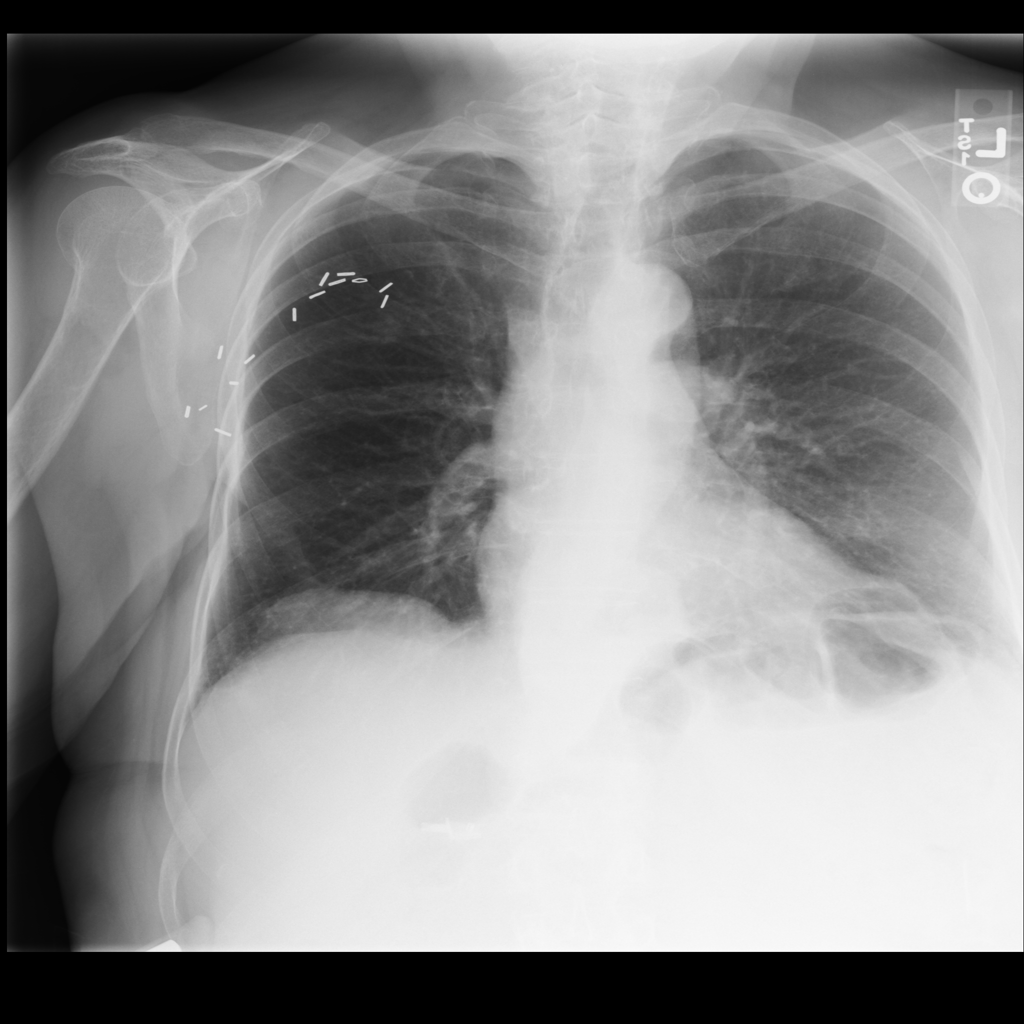

In [91]:
file_name = '/home/ec2-user/SageMaker/images/00000003_002.png'
# test image
from IPython.display import Image
Image(file_name)  

In [92]:
import json
import numpy as np
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
print(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
print(index)
disease_list = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', \
                   'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', \
                   'Hernia']


print("Top Result: label - " + disease_list[index] + ", probability - " + str(result[index]))
for idx, val in enumerate(result):
    print('%s:\t%f \n'%(disease_list[idx], result[idx]), end='')

[0.38234829902648926, 0.038168564438819885, 0.16616091132164001, 0.04293233901262283, 0.002641416620463133, 0.018540311604738235, 0.046365100890398026, 0.15679754316806793, 0.011948543600738049, 0.047599438577890396, 0.012354630045592785, 0.05002850294113159, 0.02129177376627922, 0.02462446503341198]
0
Top Result: label - Atelectasis, probability - 0.38234829902648926
Atelectasis:	0.382348 
Consolidation:	0.038169 
Infiltration:	0.166161 
Pneumothorax:	0.042932 
Edema:	0.002641 
Emphysema:	0.018540 
Fibrosis:	0.046365 
Effusion:	0.156798 
Pneumonia:	0.011949 
Pleural_Thickening:	0.047599 
Cardiomegaly:	0.012355 
Nodule:	0.050029 
Mass:	0.021292 
Hernia:	0.024624 
